In [337]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest
from cycler import cycler

In [338]:
harmony_data = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Reservoir Engineering\Datasets\Oil Production\Harmony_data.csv')
IHS_data = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Reservoir Engineering\Datasets\Oil Production\IHS_data.csv')
train_data = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Reservoir Engineering\Datasets\Oil Production\production_data_train.csv', parse_dates=[['Month', 'Year']])
test_data = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Reservoir Engineering\Datasets\Oil Production\production_data_test.csv', parse_dates=['date'])
test_APIs = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Reservoir Engineering\Datasets\Oil Production\Test_APIs.csv')
test_APIs.shape, harmony_data.shape, IHS_data.shape, train_data.shape, test_data.shape,

((1134, 1), (8930, 7), (9224, 14), (394074, 9), (6489, 11))

## Exploratory Data Analysis

In [339]:
harmony_data.head(3)

,API,LATERAL_LENGTH_BLEND,PROP_PER_FOOT,WATER_PER_FOOT,GOR_30,GOR_60,GOR_90
0,5123371740000,9056,1025.8680,790.7205,2300.919963,2290.231375,2171.635752
1,5123377360000,4101,NaN,NaN,3786.669639,3838.096579,4012.142621
2,5123378210000,4161,916.0801,839.9280,2399.490505,2291.864862,2472.275585


In [340]:
IHS_data.head(2)

,API,PermitDate,SpudDate,CompletionDate,FirstProductionDate,operatorNameIHS,formation,BasinName,StateName,CountyName,LatWGS84,LonWGS84,BottomHoleLatitude,BottomHoleLongitude
0,33105037530000,2014-09-10,2014-12-31,2015-05-05,2015-03-01 00:00:00.000,CONTINENTAL RESOURCES INCORPORATED,BAKKEN,WILLISTON BASIN,NORTH DAKOTA,WILLIAMS,48.227596,-103.299600,48.2546,-103.29997
1,33105032020000,2013-09-09,2013-11-02,2014-04-28,2014-04-01 00:00:00.000,CONTINENTAL RESOURCES INCORPORATED,BAKKEN,WILLISTON BASIN,NORTH DAKOTA,WILLIAMS,48.230954,-103.189754,48.1983,-103.19195


In [341]:
train_data.head(2)

,Month_Year,API,Liquid,Gas,RatioGasOil,Water,PercentWater,DaysOn,_LastUpdate
0,2015-03-01,33053063590000,17186,26624,1.549168,8213,0.477889,16,2016-08-11 14:03:14.000
1,2015-04-01,33053063590000,18796,21796,1.159608,7255,0.385986,30,2016-08-11 14:03:14.000


In [342]:
test_data.head(2)

,API,Year,Month,Liquid,Gas,RatioGasOil,Water,PercentWater,DaysOn,_LastUpdate,date
0,33053052530100,2014,7,19518,34414,1.763193,10786,0.552618,31,2016-04-06 13:48:08.990,2014-07-01
1,33053052530100,2014,8,18632,32250,1.730893,9959,0.534511,31,2016-04-06 13:48:08.990,2014-08-01


In [343]:
train_data.Month_Year.describe(datetime_is_numeric=True)

count                           394074
mean     2016-10-08 05:38:51.759010048
min                1977-10-01 00:00:00
25%                2015-11-01 00:00:00
50%                2016-11-01 00:00:00
75%                2017-12-01 00:00:00
max                2019-02-01 00:00:00
Name: Month_Year, dtype: object

In [344]:
test_data.date.describe(datetime_is_numeric=True)

count                             6489
mean     2015-08-12 07:16:43.606102528
min                2008-09-01 00:00:00
25%                2014-11-01 00:00:00
50%                2015-05-01 00:00:00
75%                2016-01-01 00:00:00
max                2019-01-01 00:00:00
Name: date, dtype: object

In [345]:
test_data.set_index('date', inplace=True)
test_data.drop(['Year','Month'], axis=1, inplace=True)

In [346]:
test_data.head(2)

,API,Liquid,Gas,RatioGasOil,Water,PercentWater,DaysOn,_LastUpdate
date,,,,,,,,
2014-07-01,33053052530100,19518,34414,1.763193,10786,0.552618,31,2016-04-06 13:48:08.990
2014-08-01,33053052530100,18632,32250,1.730893,9959,0.534511,31,2016-04-06 13:48:08.990


In [347]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394074 entries, 0 to 394073
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Month_Year    394074 non-null  datetime64[ns]
 1   API           394074 non-null  int64         
 2   Liquid        394074 non-null  int64         
 3   Gas           394074 non-null  int64         
 4   RatioGasOil   394074 non-null  float64       
 5   Water         394074 non-null  int64         
 6   PercentWater  394074 non-null  float64       
 7   DaysOn        394074 non-null  int64         
 8   _LastUpdate   394074 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(5), object(1)
memory usage: 27.1+ MB


#### Checking null values

In [348]:
# Check for missing values
train_data.isnull().sum()

Month_Year      0
API             0
Liquid          0
Gas             0
RatioGasOil     0
Water           0
PercentWater    0
DaysOn          0
_LastUpdate     0
dtype: int64

In [349]:
IHS_data.isnull().sum()

API                      0
PermitDate               0
SpudDate                 0
CompletionDate           0
FirstProductionDate    183
operatorNameIHS          0
formation                0
BasinName                0
StateName                0
CountyName               0
LatWGS84                 0
LonWGS84                 0
BottomHoleLatitude       0
BottomHoleLongitude      0
dtype: int64

In [350]:
harmony_data.isnull().sum()

API                       0
LATERAL_LENGTH_BLEND      0
PROP_PER_FOOT           460
WATER_PER_FOOT          633
GOR_30                  135
GOR_60                  135
GOR_90                  135
dtype: int64

### Compare the number of wells

In [351]:
# IHS_data Number of wells
IHS_data.API.unique().shape

(8930,)

In [352]:
# Harmony_data Number of wells
harmony_data.API.unique().shape

(8930,)

In [353]:
# Train_data + test_data number of wells
train_data.API.unique().shape[0] + test_data.API.unique().shape[0]

8973

In [354]:
# test_data Number of wells
test_data.API.unique().shape

(1129,)

In [355]:
# Get repetead wells in train and test data
repetead_wells = []
for well in train_data.API.unique():
    if well in test_data.API.unique():
        repetead_wells.append(well)

print(len(repetead_wells))

43


#### Check values of each column

In [356]:
# Compare the same WELL in test and test data
train_data[(train_data['API']) == 42301322730000][5:10]

,Month_Year,API,Liquid,Gas,RatioGasOil,Water,PercentWater,DaysOn,_LastUpdate
393178,2016-11-01,42301322730000,2232,32100,14.381720,27628,12.378136,0,2018-07-08 10:03:10.183
393179,2016-12-01,42301322730000,2506,31466,12.556265,27082,10.806864,0,2018-07-08 10:03:10.183
393180,2017-01-01,42301322730000,2484,34719,13.977053,29882,12.029791,0,2018-07-08 10:03:10.183
393181,2017-02-01,42301322730000,2180,26156,11.998165,22512,10.326606,0,2018-07-08 10:03:10.183
393182,2017-03-01,42301322730000,2281,22903,10.040772,19712,8.641824,0,2018-11-04 10:19:16.577


In [357]:
# Compare the same WELL in test and test data
test_data[(test_data['API'] == 42301322730000)]

,API,Liquid,Gas,RatioGasOil,Water,PercentWater,DaysOn,_LastUpdate
date,,,,,,,,
2015-02-01,42301322730000,10801,36697,3.397556,31584,2.924174,0,2018-11-04 10:19:16.577
2015-03-01,42301322730000,17497,78231,4.471109,67331,3.848145,0,2018-11-04 10:19:16.577
2015-04-01,42301322730000,12283,65415,5.325653,56301,4.583652,0,2018-11-04 10:19:16.577
2015-05-01,42301322730000,9661,64795,6.706863,55767,5.772384,0,2018-11-04 10:19:16.577


In [358]:
# Check if all the wells in test data are in harmony_data and IHS_data
set(test_APIs.index.unique()) - set(harmony_data.index.unique()), set(test_APIs.index.unique()) - set(IHS_data.index.unique())

(set(), set())

In [359]:
# IHS data has more observations than harmony data and wells, it is necessary to verify data that are duplicated 
IHS_data[IHS_data.API.isin(list(IHS_data.API[IHS_data.API.duplicated()]))].head(6)

,API,PermitDate,SpudDate,CompletionDate,FirstProductionDate,operatorNameIHS,formation,BasinName,StateName,CountyName,LatWGS84,LonWGS84,BottomHoleLatitude,BottomHoleLongitude
272,42301320940000,2014-01-02,2014-02-19,2014-04-17,NaN,WPX ENERGY PRODUCTION LLC,BONE SPRING,PERMIAN BASIN,TEXAS,LOVING,31.942399,-103.870208,31.95571,-103.86969
281,42301322750000,2014-08-09,2015-04-08,2015-07-21,NaN,EOG RESOURCES INCORPORATED,BONE SPRING,PERMIAN BASIN,TEXAS,LOVING,31.971822,-103.626594,31.95668,-103.62589
289,42301323710000,2014-10-10,2014-12-18,2015-05-27,2016-01-01 00:00:00.000,APACHE CORPORATION,BONE SPRING,PERMIAN BASIN,TEXAS,LOVING,31.751439,-103.614968,31.73676,-103.63004
290,42301323710000,2014-10-10,2014-12-18,2015-05-27,2015-05-01 00:00:00.000,APACHE CORPORATION,BONE SPRING,PERMIAN BASIN,TEXAS,LOVING,31.751439,-103.614968,31.73676,-103.63004
310,42301326020000,2015-05-21,2015-06-20,2015-08-05,NaN,EOG RESOURCES INCORPORATED,BONE SPRING,PERMIAN BASIN,TEXAS,LOVING,31.986463,-103.619420,31.99981,-103.62003
316,42109325790000,2013-05-29,2013-08-10,2014-02-17,NaN,COG OPERATING LIMITED LIABILITY CORP,BONE SPRING,PERMIAN BASIN,TEXAS,CULBERSON,31.986781,-104.033066,31.99947,-104.03214


In [360]:
# Drop duplicated wells in IHS data
IHS_data_nd = IHS_data.drop_duplicates(subset=['API']).reset_index()
IHS_data_nd.shape

(8930, 15)

In [361]:
# Map the IHS_data to train_dat and test_data
for column in IHS_data_nd.columns:
    train_data[column + '_new'] = train_data['API'].map(dict(zip(IHS_data_nd.API, IHS_data_nd[column])))

for column in IHS_data_nd.columns:
    test_data[column + '_new'] = test_data['API'].map(dict(zip(IHS_data_nd.API, IHS_data_nd[column])))

In [362]:
# Map the harmony_data to the test_data
for column in harmony_data.columns:
    train_data[column + '_new'] = train_data['API'].map(dict(zip(harmony_data.API, harmony_data[column])))

for column in harmony_data.columns:
    test_data[column + '_new'] = test_data['API'].map(dict(zip(harmony_data.API, harmony_data[column])))

In [363]:
# Drop columns with no relevance
train_df = train_data.drop(['index_new', 'API_new','PermitDate_new','FirstProductionDate_new','SpudDate_new','CompletionDate_new','LatWGS84_new','LonWGS84_new', 'GOR_30_new', 'GOR_60_new', 'GOR_90_new', '_LastUpdate'], axis=1)
test_df = test_data.drop(['index_new', 'API_new','PermitDate_new','FirstProductionDate_new','SpudDate_new','CompletionDate_new','LatWGS84_new','LonWGS84_new', 'GOR_30_new', 'GOR_60_new', 'GOR_90_new', '_LastUpdate'], axis=1)

In [364]:
# Rename date column to match test_data
train_df.rename(columns={'Month_Year':'date'}, inplace=True)

In [365]:
train_df.set_index('date', inplace=True)

In [366]:
# Check if test_df and test_df have the same columns
set(train_df.columns) - set(test_df.columns)

set()

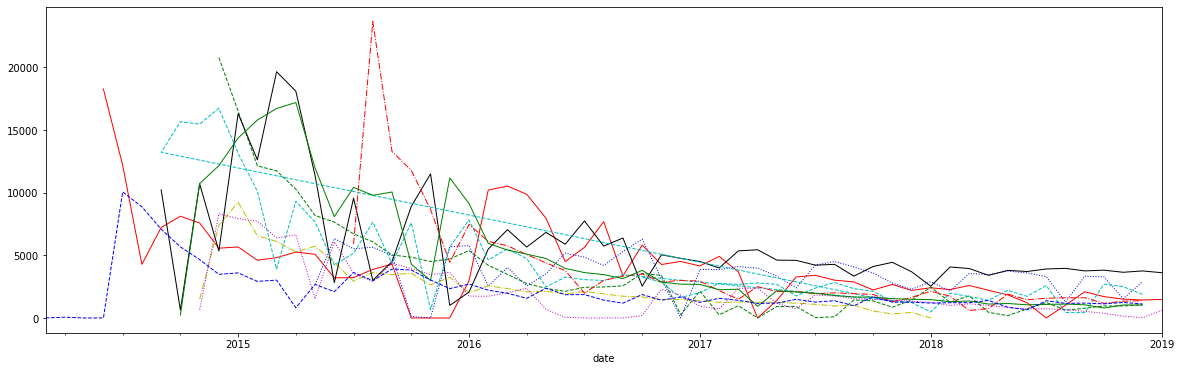

In [367]:
# Plot some random wells from train_df to see their behaviour
random_wells = np.random.choice(train_df.API.unique(), 10)

for well in random_wells:
    train_df[(train_df['API'] == well)]['Liquid'].plot(figsize=(20, 6))

plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y', 'k', 'c', 'm', 'r', 'g', 'b', 'y', 'k', 'c', 'm','b','y']) + cycler('linestyle', ['-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--', ':', '-.'])))
plt.rc('lines', linewidth=1)

In [368]:
test_df.index.max(), test_df.index.min(), train_df.index.max(), train_df.index.min()

(Timestamp('2019-01-01 00:00:00'),
 Timestamp('2008-09-01 00:00:00'),
 Timestamp('2019-02-01 00:00:00'),
 Timestamp('1977-10-01 00:00:00'))

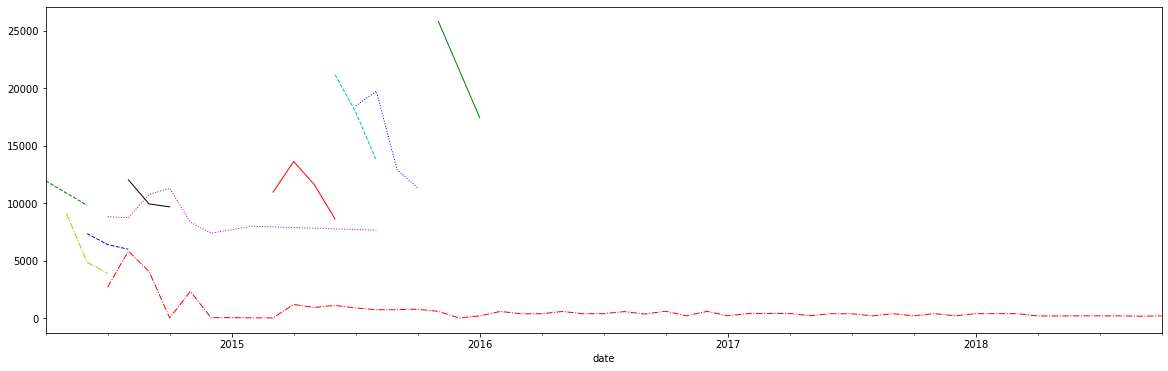

In [369]:
# Plot some random wells from test_df to see their behaviour
random_wells_test = np.random.choice(test_df.API.unique(), 10)

for well in random_wells_test:
    test_df[(test_df['API'] == well)]['Liquid'].plot(figsize=(20, 6))

plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y', 'k', 'c', 'm', 'r', 'g', 'b', 'y', 'k', 'c', 'm','b','y']) + cycler('linestyle', ['-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--', ':', '-.'])))
plt.rc('lines', linewidth=1)

In [370]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 394074 entries, 2015-03-01 to 2018-09-01
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   API                       394074 non-null  int64  
 1   Liquid                    394074 non-null  int64  
 2   Gas                       394074 non-null  int64  
 3   RatioGasOil               394074 non-null  float64
 4   Water                     394074 non-null  int64  
 5   PercentWater              394074 non-null  float64
 6   DaysOn                    394074 non-null  int64  
 7   operatorNameIHS_new       394074 non-null  object 
 8   formation_new             394074 non-null  object 
 9   BasinName_new             394074 non-null  object 
 10  StateName_new             394074 non-null  object 
 11  CountyName_new            394074 non-null  object 
 12  BottomHoleLatitude_new    394074 non-null  float64
 13  BottomHoleLongitude_new   39

In [371]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6489 entries, 2014-07-01 to 2015-03-01
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   API                       6489 non-null   int64  
 1   Liquid                    6489 non-null   int64  
 2   Gas                       6489 non-null   int64  
 3   RatioGasOil               6489 non-null   float64
 4   Water                     6489 non-null   int64  
 5   PercentWater              6489 non-null   float64
 6   DaysOn                    6489 non-null   int64  
 7   operatorNameIHS_new       6489 non-null   object 
 8   formation_new             6489 non-null   object 
 9   BasinName_new             6489 non-null   object 
 10  StateName_new             6489 non-null   object 
 11  CountyName_new            6489 non-null   object 
 12  BottomHoleLatitude_new    6489 non-null   float64
 13  BottomHoleLongitude_new   6489 non-null   flo

In [372]:
# Check the features with missing values
train_df[train_df.PROP_PER_FOOT_new.isnull()].groupby('API').mean()[:3]

,Liquid,Gas,RatioGasOil,Water,PercentWater,DaysOn,BottomHoleLatitude_new,BottomHoleLongitude_new,LATERAL_LENGTH_BLEND_new,PROP_PER_FOOT_new,WATER_PER_FOOT_new
API,,,,,,,,,,,
5001097800000,307.812500,363.312500,1.148123,647.104167,1.172769,27.666667,39.92629,-104.71585,3983.0,NaN,NaN
5001097830000,317.472727,823.890909,1.874774,328.090909,0.455979,26.018182,39.92745,-104.71586,4027.0,NaN,NaN
5001098450000,4648.595238,11096.666667,3.275740,226.880952,0.057842,21.619048,39.95921,-104.84774,4315.0,NaN,NaN


In [415]:
# Concatenate train_df and test_df
df = pd.concat([train_df, test_df], axis=0)

In [416]:
# Fill the missing values with the bfill method
df.fillna(method='bfill', inplace=True)

In [417]:
# Change API column to string
df['API'] = df['API'].astype(str)

In [418]:
df.BasinName_new

date
2015-03-01    WILLISTON BASIN
2015-04-01    WILLISTON BASIN
2015-05-01    WILLISTON BASIN
2015-06-01    WILLISTON BASIN
2015-07-01    WILLISTON BASIN
                   ...       
2014-09-01      PERMIAN BASIN
2014-11-01      PERMIAN BASIN
2014-12-01      PERMIAN BASIN
2015-01-01      PERMIAN BASIN
2015-03-01      PERMIAN BASIN
Name: BasinName_new, Length: 400563, dtype: object

In [419]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 400563 entries, 2015-03-01 to 2015-03-01
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   API                       400563 non-null  object 
 1   Liquid                    400563 non-null  int64  
 2   Gas                       400563 non-null  int64  
 3   RatioGasOil               400563 non-null  float64
 4   Water                     400563 non-null  int64  
 5   PercentWater              400563 non-null  float64
 6   DaysOn                    400563 non-null  int64  
 7   operatorNameIHS_new       400563 non-null  object 
 8   formation_new             400563 non-null  object 
 9   BasinName_new             400563 non-null  object 
 10  StateName_new             400563 non-null  object 
 11  CountyName_new            400563 non-null  object 
 12  BottomHoleLatitude_new    400563 non-null  float64
 13  BottomHoleLongitude_new   40

In [422]:
# Function that transform object variables into categorical variables
def transform_object_variables(df):
    for label, content in df.items():
        if content.dtype == 'object':
            df[label] = pd.Categorical(content).codes + 1

In [423]:
transform_object_variables(df)

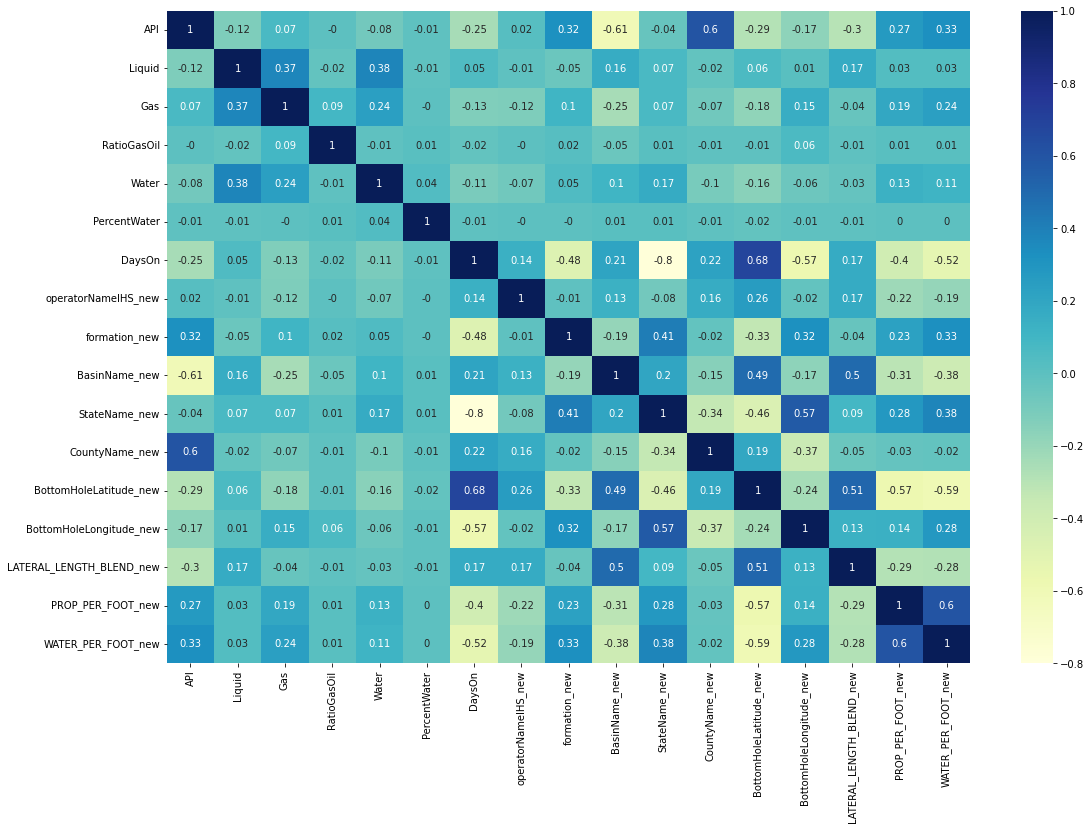

In [378]:
# Plotting correlation matrix
plt.figure(figsize=(18, 12))
sns.heatmap(round(df.corr(),2), annot=True, cmap='YlGnBu');

In [420]:
df.shape

(400563, 17)

In [424]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 400563 entries, 2015-03-01 to 2015-03-01
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   API                       400563 non-null  int16  
 1   Liquid                    400563 non-null  int64  
 2   Gas                       400563 non-null  int64  
 3   RatioGasOil               400563 non-null  float64
 4   Water                     400563 non-null  int64  
 5   PercentWater              400563 non-null  float64
 6   DaysOn                    400563 non-null  int64  
 7   operatorNameIHS_new       400563 non-null  int16  
 8   formation_new             400563 non-null  int8   
 9   BasinName_new             400563 non-null  int8   
 10  StateName_new             400563 non-null  int8   
 11  CountyName_new            400563 non-null  int8   
 12  BottomHoleLatitude_new    400563 non-null  float64
 13  BottomHoleLongitude_new   40

In [411]:
df.head()

,API,Liquid,Gas,Water,BasinName_new,LATERAL_LENGTH_BLEND_new
date,,,,,,
2015-03-01,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-01,2459.0,18796.0,21796.0,7255.0,3.0,9762.0
2015-05-01,2459.0,14626.0,15988.0,4213.0,3.0,9762.0
2015-06-01,2459.0,10421.0,12311.0,2717.0,3.0,9762.0
2015-07-01,2459.0,9777.0,11254.0,2399.0,3.0,9762.0


In [425]:
df.drop(['RatioGasOil', 'PercentWater', 'DaysOn', 'operatorNameIHS_new','formation_new','StateName_new','CountyName_new', 'BottomHoleLatitude_new','BottomHoleLongitude_new','PROP_PER_FOOT_new', 'WATER_PER_FOOT_new'], axis=1, inplace=True)

In [426]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 400563 entries, 2015-03-01 to 2015-03-01
Data columns (total 6 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   API                       400563 non-null  int16
 1   Liquid                    400563 non-null  int64
 2   Gas                       400563 non-null  int64
 3   Water                     400563 non-null  int64
 4   BasinName_new             400563 non-null  int8 
 5   LATERAL_LENGTH_BLEND_new  400563 non-null  int64
dtypes: int16(1), int64(4), int8(1)
memory usage: 16.4 MB


In [427]:
df_1 = df.reset_index()
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400563 entries, 0 to 400562
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   date                      400563 non-null  datetime64[ns]
 1   API                       400563 non-null  int16         
 2   Liquid                    400563 non-null  int64         
 3   Gas                       400563 non-null  int64         
 4   Water                     400563 non-null  int64         
 5   BasinName_new             400563 non-null  int8          
 6   LATERAL_LENGTH_BLEND_new  400563 non-null  int64         
dtypes: datetime64[ns](1), int16(1), int64(4), int8(1)
memory usage: 16.4 MB


In [388]:
np.random.seed(82)
test_well = df_1[(df_1.API == np.random.choice(df_1.API.unique(), 1)[0])]
test_well.head()

,date,API,Liquid,Gas,Water,BasinName_new,LATERAL_LENGTH_BLEND_new
229801,2014-02-01,4509.0,13380.0,177168.0,0.0,2.0,9910.0
229802,2014-03-01,4509.0,15038.0,202678.0,63276.0,2.0,9910.0
229803,2014-04-01,4509.0,20521.0,269656.0,84187.0,2.0,9910.0
229804,2014-05-01,4509.0,16848.0,240905.0,75211.0,2.0,9910.0
229805,2014-06-01,4509.0,14725.0,227761.0,71107.0,2.0,9910.0


In [389]:
test_well.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59 entries, 229801 to 229859
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      59 non-null     datetime64[ns]
 1   API                       59 non-null     float64       
 2   Liquid                    59 non-null     float64       
 3   Gas                       59 non-null     float64       
 4   Water                     59 non-null     float64       
 5   BasinName_new             59 non-null     float64       
 6   LATERAL_LENGTH_BLEND_new  59 non-null     float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 3.7 KB


In [382]:
test_well[test_well.index >= test_well.Liquid.idxmax()].head(5)

,API,Liquid,Gas,Water,BasinName_new,LATERAL_LENGTH_BLEND_new
date,,,,,,
2015-09-01,5259,18979,50186,63970,2,4458
2015-10-01,5259,9976,23791,30325,2,4458
2015-11-01,5259,9808,40827,52041,2,4458
2015-12-01,5259,645,3315,4225,2,4458
2016-01-01,5259,2688,7926,10103,2,4458


In [383]:
for well in df.API.unique():
    df[(df.API == well)] = df[(df.API == well)][(df[(df.API == well)].index >= df[(df.API == well)].Liquid.idxmax())]

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_2052\3986820988.py:2: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  df[(df.API == well)] = df[(df.API == well)][(df[(df.API == well)].index >= df[(df.API == well)].Liquid.idxmax())]


ValueError: cannot reindex on an axis with duplicate labels

In [ ]:
df.index.duplicated().sum()

400066

In [ ]:
df[(df.API == 5259)].head(5)

,API,Liquid,Gas,Water,BasinName_new,LATERAL_LENGTH_BLEND_new
date,,,,,,
2015-08-01,5259.0,2642.0,10662.0,13590.0,2.0,4458.0
2015-09-01,5259.0,18979.0,50186.0,63970.0,2.0,4458.0
2015-10-01,5259.0,9976.0,23791.0,30325.0,2.0,4458.0
2015-11-01,5259.0,9808.0,40827.0,52041.0,2.0,4458.0
2015-12-01,5259.0,645.0,3315.0,4225.0,2.0,4458.0


#### Splitting data into train and test sets

In [ ]:
Y_train_set = df.Liquid[:train_df.shape[0]]
exo_train_set = df[:train_df.shape[0]].drop(['Liquid'], axis=1)
Y_test_set = df.Liquid[train_df.shape[0]:]
exo_test_set = df[train_df.shape[0]:].drop(['Liquid'], axis=1)

In [ ]:
exo_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 394074 entries, 2015-03-01 00:00:00 to 2018-09-01 00:00:00
Data columns (total 5 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   API                       394074 non-null  int16
 1   Gas                       394074 non-null  int64
 2   Water                     394074 non-null  int64
 3   BasinName_new             394074 non-null  int8 
 4   LATERAL_LENGTH_BLEND_new  394074 non-null  int64
dtypes: int16(1), int64(3), int8(1)
memory usage: 13.2+ MB


In [ ]:
Y_train_set.info()

<class 'pandas.core.series.Series'>
Index: 394074 entries, 2015-03-01 00:00:00 to 2018-09-01 00:00:00
Series name: Liquid
Non-Null Count   Dtype
--------------   -----
394074 non-null  int64
dtypes: int64(1)
memory usage: 6.0+ MB


In [ ]:
# mod_auar_li = auto_arima(Y_train_set, exogenous=exo_train_set[['API', 'Gas', 'Water','BasinName_new','LATERAL_LENGTH_BLEND_new']], m=5, max_p=5, max_q=5)

In [ ]:
[exo_train_set.columns.values]

[array(['API', 'Gas', 'Water', 'BasinName_new', 'LATERAL_LENGTH_BLEND_new'],
       dtype=object)]